In [1]:
# Import required libraries:

import numpy as np
import pandas as pd
import os # this library provides easy access to the local file directories

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 # opencv library for image processing purposes

from sklearn import model_selection
from sklearn import neighbors

In [2]:
normalization_size = (128, 128) # choose the size of normalization
grid_size = (8, 8) # choose the grid pattern. Please choose them 
hist_bin_size = (20,20,20) # Choose the bin size for histograms of H, S, and V separately

In [3]:
def ColorHistogramOfHSV(image, normalization_size, grid_size, hist_bin_size):
    ## This function takes an HSV coded image and returns its color histogram.
    
    hist = np.zeros((np.sum(hist_bin_size)*grid_size[0]*grid_size[1] , 1)) # create an empty array for the descriptor with proper dimensions
    
    # Scan the image by the windows and find the histogram of each window. Then, concatenate them column wise:
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
                    
            # Create a mask that has the same size with images. The mask will be dark (0) in all areas except the
            # desired window location. Window will be white (255).
            mask = np.zeros(normalization_size, np.uint8)
            mask[int(i*(normalization_size[0]/grid_size[0])) : int((i+1)*(normalization_size[0]/grid_size[0])), int(j*(normalization_size[1]/grid_size[1])) : int((j+1)*(normalization_size[1]/grid_size[1]))] = 255
                    
            # Find the L1 norm histograms for each H, S, and V. Then, concatenate them to together:
            hist_H = cv2.calcHist([image],[0],mask,[hist_bin_size[0]],[0,180])
            hist_H = hist_H / np.sum(np.abs(hist_H)) # Divide the histogram array by its L1 norm, so it adds up to 1.
            hist_S = cv2.calcHist([image],[1],mask,[hist_bin_size[1]],[0,256])
            hist_S = hist_S / np.sum(np.abs(hist_S))
            hist_V = cv2.calcHist([image],[2],mask,[hist_bin_size[2]],[0,256])
            hist_V = hist_V / np.sum(np.abs(hist_V))
                    
            hist_window = np.concatenate((hist_H, hist_S, hist_V), axis=0) # This is the histogram of a single window
            
            hist[(i*grid_size[0]+j)*np.sum(hist_bin_size) : (i*grid_size[0]+j+1)*np.sum(hist_bin_size) , 0] = hist_window[:,0]
            
    return hist
    
    

In [12]:
def GradientHistogramOfGrayscale(image, normalization_size, grid_size, hist_bin_size):
    ## This function takes an HSV coded image and returns its color histogram.
    
    hist = np.zeros((hist_bin_size[0]*grid_size[0]*grid_size[1] , 1)) # create an empty array for the descriptor with proper dimensions
    
    # Scan the image by the windows and find the histogram of each window. Then, concatenate them column wise:
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            
            Gradx = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=3) # By using cv2.CV_32F, gradient of each pixel will be 32-bit floating numbers
            Grady = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=3) # 
            
            # Find the angles between the gradients in radians:
            GradRadian = np.arctan2(Grady,Gradx) # Each element is between -3.14-3.14
            
            # Create a mask that has the same size with images. The mask will be dark (0) in all areas except the
            # desired window location. Window will be white (255).
            mask = np.zeros(normalization_size, np.uint8)
            mask[int(i*(normalization_size[0]/grid_size[0])) : int((i+1)*(normalization_size[0]/grid_size[0])), int(j*(normalization_size[1]/grid_size[1])) : int((j+1)*(normalization_size[1]/grid_size[1]))] = 255
                    
            # Find the L1 norm histograms of each window:
            hist_window = cv2.calcHist([GradRadian],[0],mask,[hist_bin_size[0]],[-np.pi,np.pi])
            hist_window = hist_window / np.sum(np.abs(hist_window)) # Divide the histogram array by its L1 norm, so it adds up to 1.

            # Concatenate them to together:
            hist[(i*grid_size[0]+j)*hist_bin_size[0] : (i*grid_size[0]+j+1)*hist_bin_size[0] , 0] = hist_window[:,0]
            
    return hist

In [13]:
# folder1 should be the directory of the SKU_Recognition_Dataset folder. Change it accordingly. 
folder1 = 'C:/Users/Mecha/Desktop/Graduate courses/EE 58J Data Mining/HW1/SKU_Recognition_Dataset'

# We will use 3 for loops in order to go through all categories, all SKUs and all images respectively.
# For each image, we will first read, then normalize its size, and finally extract all desired descriptors.

y = [] # We will collect the labels of dataset in this list
X = [] # This will be our dataset
cls = 0
classNameDic = {}
categoryDic  = {}
categoryList = []

for counter, file1 in enumerate(os.listdir(folder1)): # .listdir() method willl return a list that contains all the folder names in the folder1
    folder2 = folder1+'/'+file1   # Through folder1 -> folder2 -> folder3 -> folder4, we go one step deeper in the directory
    categoryList.append(file1)
    print('Please wait. {} / 5 is done'.format(counter))
    for file2 in os.listdir(folder2):
        classNameDic.update({cls: file2})
        categoryDic.update({cls: file1})
        folder3 = folder2+'/'+file2  # folder3 is the directory of a SKU folder that contains approximately 100 jpeg images
        for file3 in os.listdir(folder3):
            
            # Create the direct path to a single image:
            folder4 = folder3+'/'+file3
            
            # Read the image as a (x,y,3) numpy array:
            image = cv2.imread(folder4)
            
            # Resize it to (128,128,3) array:
            image = cv2.resize(image, (128,128))
            
            # Convert the BGR to HSV format:
            image_HSV = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
            
            # Find the histogram descriptor of HSV image:
            ColorHistogram = ColorHistogramOfHSV(image_HSV, normalization_size, grid_size, hist_bin_size)
            
            # Convert the BGR to grayscale format:
            image_Gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            
            # Find the gradient histogram of grayscale image:
            GradientHistogram = GradientHistogramOfGrayscale(image_Gray, normalization_size, grid_size, hist_bin_size)
            
            # Concatenate two histograms:
            ConHistogram = np.concatenate((ColorHistogram, GradientHistogram))
            
            y.append(cls)
            #X.append(GradientHistogram[:,0])
            #X.append(ColorHistogram[:,0])
            X.append(ConHistogram[:,0])
        cls += 1
            
X = np.asarray(X)
y = np.asarray(y)

0
1
2
3
4


In [18]:
# Split the data into test and training data. By choosing stratify=y, each class will be split approximately by 20-80 ratio. 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                random_state = 2,
                                                stratify=y,
                                                test_size=0.20)

In [19]:
# Create a NN model with KNN model by chosing K=1. p parameter determines the order of the norm.
# When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
NNmodel = neighbors.KNeighborsClassifier(n_neighbors=1, p=1, metric='minkowski')

# Train the model:
NNmodel.fit(X_train, y_train)

# Test the model by estimating the classes of X_test
y_estimated = NNmodel.predict(X_test)

# Find the accuracy of the estimation:
score = 100 * sum(y_estimated == y_test) / y_estimated.shape[0]

print('Accuracy of the classifier is {}'.format(score))

69.65750120598167

Category accuracies are as follows:
{'confectionery': 72.22222222222223, 'icecream': 55.47785547785548, 'laundry': 72.96650717703349, 'softdrinks-I': 55.693069306930695, 'softdrinks-II': 92.40196078431373}


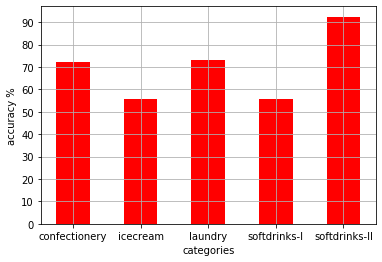

In [58]:
# Find the accuracies of each category separately and plot it:

categoryAccuracies = dict.fromkeys(categoryList)
truth = (y_estimated == y_test)

for cat in categoryList:
    sample = 0
    true_est = 0
    for i, yy in enumerate(y_test):
        if categoryDic[yy] == cat:
            sample += 1
            true_est += truth[i]
    categoryAccuracies[cat] = 100 * true_est / sample
    
print('Category accuracies are as follows:')
print(categoryAccuracies)

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 100, 10))

plt.bar(categoryAccuracies.keys(), categoryAccuracies.values(), width=0.5, color='r')

plt.xlabel('categories')
plt.ylabel('accuracy %')
plt.grid(True)

In [57]:
min_class = classNameDic[0]
minValue = 100
minClass = 0
for cls in classNameDic.keys():
    acc = 100 * sum(y_estimated[np.where(y_test == cls)] == y_test[np.where(y_test == cls)]) / y_test[np.where(y_test == cls)].shape[0]
    
    if acc < minValue:
        minClass = cls
        minValue = acc
print('Lowest class accuracy is {}'.format(minValue))
print('Most confused class is {}'.format(classNameDic[minClass]))

Lowest class accuracy is 20.0
Most confused class is sku.70
